In [1]:
%matplotlib inline

import os
import sys

# Useful imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.layers.recurrent import LSTM, GRU

# Local scripts
import model
import preprocessing
import read_data
import viz

Using TensorFlow backend.


If you are only interested in reproducing my results, the networks are already pre-trained and ready to be used.  The evaluations, etc. can still take a fair amount of time, but using the pre-trained models can really speed things up.

In [2]:
READ_PRE_TRAINED_MODELS = False
PRE_TRAINED_EPOCH = 9

In [3]:
FEATURES_READ = [
    'SymH',  # What we are trying to predict,
    'Bz',
    'By',  # Necessary for calculating the clock angle.
    'DynamicPressure'
]
omni_data = read_data.read_omni_db(FEATURES_READ)

In [4]:
omni_data.describe()

,SymH,By,Bz,DynamicPressure
count,3.786879e+06,2.572784e+06,2.572784e+06,2.465132e+06
mean,-1.429043e+01,6.014436e-02,1.701979e-02,2.268229e+00
std,2.228224e+01,4.342207e+00,3.411682e+00,1.825878e+00
min,-5.990000e+02,-4.554000e+01,-5.151000e+01,1.000000e-02
25%,-2.200000e+01,-2.780000e+00,-1.740000e+00,1.250000e+00
50%,-1.000000e+01,4.000000e-02,2.000000e-02,1.830000e+00
75%,-1.000000e+00,2.890000e+00,1.760000e+00,2.710000e+00
max,1.420000e+02,5.660000e+01,5.410000e+01,9.777000e+01


SymH is a very easy measurement to make and since it is ground based, there are basically no missing values.  The magnetic field components and Solar Wind parameters however have a lot more missing data...

In [5]:
missing_b_pct = np.isnan(omni_data['Bz']).sum() / float(len(omni_data))
missing_pressure_pct = np.isnan(omni_data['DynamicPressure']).sum() / float(len(omni_data))
print('Missing B percent: %s' % missing_b_pct)
print('Missing Dynamic Pressure percent: %s' % missing_pressure_pct)

Missing B percent: 0.320611622346
Missing Dynamic Pressure percent: 0.349039005924


### The IMF clock angle is probably important
The more southward the IMF, the more likely we are to get a storm.  Let's define the clock angle as the angle between the negative Z-axis and the magnetic field.  This has the advantage of having continuous values across the most interesting region (when the field is completely southward)

In [6]:
clock_angle = np.arctan2(omni_data.By, -omni_data.Bz)
omni_data = omni_data.assign(clock_angle=clock_angle)
del clock_angle

### Remove early data

Prior to August 1995, the data coverage is pretty spotty.  We can remove it from the dataset entirely.  This will probably also make it easier to split the dataset into training and testing datasets since we do not have to worry about really long sequences of missing data.

In [7]:
omni_data = omni_data[omni_data.index > pd.Timestamp('1995-08-01')]
print len(omni_data)
missing_b_pct = np.isnan(omni_data['Bz']).sum() / float(len(omni_data))
missing_pressure_pct = np.isnan(omni_data['DynamicPressure']).sum() / float(len(omni_data))
print('Missing B percent: %s' % missing_b_pct)
print('Missing Dynamic Pressure percent: %s' % missing_pressure_pct)

2253311
Missing B percent: 0.0506490227048
Missing Dynamic Pressure percent: 0.076791441572


### Fill missing with the mean of the dataset. 
This might not be the _best_ approach, but it should work OK for the time being.  Other approaches could be forward filling the data.

In [8]:
_ = omni_data.fillna({col: omni_data[col].mean() for col in omni_data.columns}, inplace=True)

In [9]:
omni_data.describe()

,SymH,By,Bz,DynamicPressure,clock_angle
count,2.253311e+06,2.253311e+06,2.253311e+06,2.253311e+06,2.253311e+06
mean,-1.224470e+01,7.962645e-02,-9.993451e-03,2.127520e+00,2.568804e-02
std,1.957057e+01,4.103176e+00,3.258576e+00,1.691478e+00,1.704027e+00
min,-4.880000e+02,-4.554000e+01,-5.151000e+01,1.000000e-02,-3.141593e+00
25%,-1.900000e+01,-2.520000e+00,-1.600000e+00,1.230000e+00,-1.488226e+00
50%,-9.000000e+00,7.962645e-02,-9.993451e-03,1.820000e+00,2.568804e-02
75%,-1.000000e+00,2.660000e+00,1.570000e+00,2.430000e+00,1.542932e+00
max,1.360000e+02,5.660000e+01,5.410000e+01,9.777000e+01,3.141593e+00


### Resample to 20min intervals

This decreases the amount of data that we need to get a decent history and should therefore help with the curse of dimensionality.

In [10]:
omni_lo_res = omni_data.resample('20T').mean()
print 'Old data size: {}, New data size: {}'.format(len(omni_data), len(omni_lo_res))

Old data size: 2253311, New data size: 563328


### Split into training and testing datasets

In [11]:
FIELDS = ['Bz', 'clock_angle', 'DynamicPressure']
FIELDS_PREDICT = ['SymH']
LOOK_BEHIND_SPAN = 15  # dataset freq is 20min so 15 points is 5 hours.
LOOK_AHEAD_SPAN = 3    # dataset freq is 20min so 3 points is 1 hour.
x_train, y_train, x_test, y_test = preprocessing.train_test_split(
    omni_lo_res,
    FIELDS,
    FIELDS_PREDICT,
    n_points_behind=LOOK_BEHIND_SPAN,
    n_points_ahead=LOOK_AHEAD_SPAN)

input_shape = (LOOK_BEHIND_SPAN, x_train.shape[2])

### Let's train some models and compare the difference between GRU and LSTM layers.

In [12]:
import itertools
params = itertools.product((LSTM, GRU), (.1, .3, .5))
models = []
for rnn_type, dropout in params:
    name = '%s-dropout-%s' % (rnn_type.__name__, dropout)
    m = model.ModelWrapper(
        model.build_model(input_shape, LOOK_AHEAD_SPAN, hidden=32, rnn_type=rnn_type, dropout=dropout),
        name=name)
    m.save_path = './model-checkpoints/'  # save in the model-checkpoints directory.
    m.save_freq = 5  # When training, save every 5 epochs.    
    model.compile_model(m)
    models.append(m)


Train the models.  Note, this can take quite a while unless you load pre-trained datasets.  Then it should be very quick :-)

In [13]:
if READ_PRE_TRAINED_MODELS:
    new_models = []
    for m in models:
        m = m.restore(os.path.join(m.save_path, m.name + '.%s.json' % PRE_TRAINED_EPOCH))
        new_models.append(m)
    models[:] = new_models
else:
    for m in models:
        # Hold out 20% of the dat a for validation.
        # Splitting the dataset at a specific point minimizes the correlation
        # between the input vectors and the validation vectors.
        n_validate = int(len(x_train) * .2)
        X = x_train[:-n_validate]
        Y = y_train[:-n_validate]
        x_validate = x_train[-n_validate:]
        y_validate = y_train[-n_validate:]
        m.fit(
            X,
            Y,
            epochs=10,
            batch_size=400,
            validation_data=(x_validate, y_validate))


Train on 315449 samples, validate on 78862 samples
Epoch 1/10
315449/315449 [==============================] - 47s - loss: 487.4109 - val_loss: 113.5373
Epoch 2/10
315449/315449 [==============================] - 50s - loss: 395.2894 - val_loss: 100.2143
Epoch 3/10
315449/315449 [==============================] - 50s - loss: 363.2222 - val_loss: 136.0205
Epoch 4/10
315449/315449 [==============================] - 50s - loss: 347.6197 - val_loss: 107.4290
Epoch 5/10
315449/315449 [==============================] - 50s - loss: 337.8409 - val_loss: 106.7782
Epoch 6/10
315449/315449 [==============================] - 46s - loss: 331.2376 - val_loss: 108.4768
Epoch 7/10
315449/315449 [==============================] - 50s - loss: 326.2043 - val_loss: 98.9591
Epoch 8/10
315449/315449 [==============================] - 51s - loss: 322.8017 - val_loss: 90.5448
Epoch 9/10
315449/315449 [==============================] - 46s - loss: 318.9349 - val_loss: 117.1712
Epoch 10/10
315449/315449 [======

In [14]:
loss = pd.DataFrame({m.name: m.loss for m in models})
val_loss = pd.DataFrame({m.name: m.val_loss for m in models})

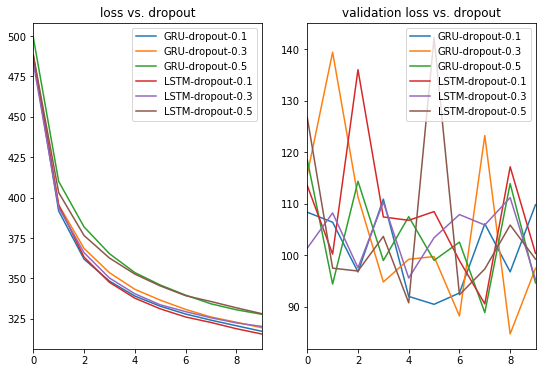

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
loss.plot(ax=ax[0], title='loss vs. dropout')
val_loss.plot(ax=ax[1], title='validation loss vs. dropout')

There doesn't seem to be a big difference between LSTM and GRU layers.  In general, lower dropout seems to lead to less loss, but the validation loss is still fluctuating quite a bit.  More epochs would be necessary to determine if there is any benefit (or harm) to further training.  The LSTM with a dropout of 0.3 seems to be the most consistent model shown here.

### Lets try a stacked RNN

In [16]:
m = model.ModelWrapper(
    model.build_model(input_shape, LOOK_AHEAD_SPAN, hidden=32, rnn_type=GRU, dropout=.1, stacks=3),
    name='GRU-stacks-3-dropout-.1-hidden-32')
m.save_path = './model-checkpoints/'
model.compile_model(m)

In [17]:
if READ_PRE_TRAINED_MODELS:
    m = m.restore(os.path.join(m.save_path, m.name + '.%s.json' % PRE_TRAINED_EPOCH))
else:
    n_validate = int(len(x_train) * .2)
    X = x_train[:-n_validate]
    Y = y_train[:-n_validate]
    x_validate = x_train[-n_validate:]
    y_validate = y_train[-n_validate:]
    m.fit(
        X,
        Y,
        epochs=10,
        batch_size=400,
        validation_data=(x_validate, y_validate))


Train on 315449 samples, validate on 78862 samples
Epoch 1/10
315449/315449 [==============================] - 89s - loss: 479.8425 - val_loss: 113.3568
Epoch 2/10
315449/315449 [==============================] - 89s - loss: 385.2782 - val_loss: 91.6622
Epoch 3/10
315449/315449 [==============================] - 89s - loss: 354.4447 - val_loss: 117.3356
Epoch 4/10
315449/315449 [==============================] - 89s - loss: 335.8759 - val_loss: 122.2873
Epoch 5/10
315449/315449 [==============================] - 89s - loss: 323.8735 - val_loss: 93.9391
Epoch 6/10
315449/315449 [==============================] - 89s - loss: 315.8588 - val_loss: 96.0381
Epoch 7/10
315449/315449 [==============================] - 89s - loss: 309.2786 - val_loss: 130.7023
Epoch 8/10
315449/315449 [==============================] - 90s - loss: 304.4782 - val_loss: 104.5416
Epoch 9/10
315449/315449 [==============================] - 88s - loss: 300.1595 - val_loss: 97.3114
Epoch 10/10
315449/315449 [========

In [18]:
import itertools
stacked_model = m

evaluate_vals = []

for m in itertools.chain([stacked_model], models):
    evaluate_vals.append(m.evaluate(x_test, y_test))

168896/168981 [============================>.] - ETA: 0s

In [19]:
for e_val, m in sorted(zip(evaluate_vals, itertools.chain([stacked_model], models))):
    print m.name, e_val, m.val_loss[-1]

GRU-dropout-0.5 182.659799299 94.6101224505
LSTM-dropout-0.3 189.531165711 95.2663345932
GRU-dropout-0.3 190.460060851 97.4626028953
LSTM-dropout-0.5 190.862825802 99.2339476132
GRU-stacks-3-dropout-.1-hidden-32 191.232006633 86.2805771555
LSTM-dropout-0.1 193.404962996 100.357465779
GRU-dropout-0.1 195.835876526 109.810225796


Adding more stacks didn't seem to improve predictive capabilities without hypertuning the parameter space.  We still get a pretty nifty result though...

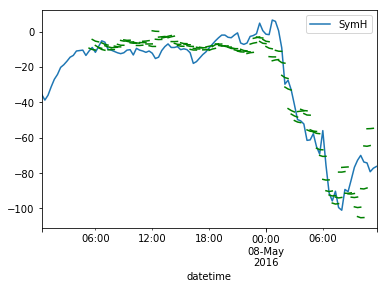

In [20]:
viz.plot_event_predictions(
        stacked_model,
        omni_lo_res,
        pd.Timestamp('2016-05-07'),
        pd.Timestamp('2016-05-08T12:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

This is the model (so far) with the lowest loss on the testing dataset.

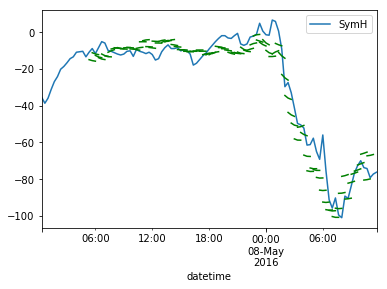

In [21]:
m = next(m for m in models if m.name == 'GRU-dropout-0.3')
viz.plot_event_predictions(
        m,
        omni_lo_res,
        pd.Timestamp('2016-05-07'),
        pd.Timestamp('2016-05-08T12:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

This is the model (so far) with the lowest validation loss after 10 epochs.  It seems to do a better job during the main phase (the steep decline of SymH), but it also tends to recover too quickly.

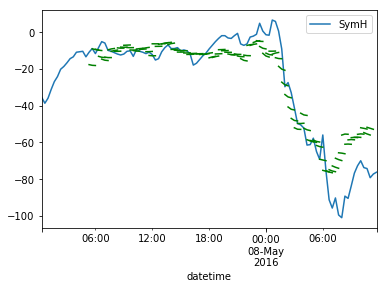

In [22]:
m = next(m for m in models if m.name == 'LSTM-dropout-0.3')
viz.plot_event_predictions(
        m,
        omni_lo_res,
        pd.Timestamp('2016-05-07'),
        pd.Timestamp('2016-05-08T12:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

### More tuning of hyper-parameters...

In [23]:
field_options = (
    ['Bz', 'By', 'DynamicPressure'],
    ['Bz', 'clock_angle', 'DynamicPressure']
)
hyper_params = list(itertools.product((16, 32), (1, 2, 3), field_options))

In [24]:
for hidden, stacks, fields in hyper_params:
    x_train, y_train, x_test, y_test = preprocessing.train_test_split(
        omni_lo_res,
        fields,
        FIELDS_PREDICT,
        n_points_behind=LOOK_BEHIND_SPAN,
        n_points_ahead=LOOK_AHEAD_SPAN)

    input_shape = (LOOK_BEHIND_SPAN, x_train.shape[2])
    
    m = model.ModelWrapper(
        model.build_model(input_shape, LOOK_AHEAD_SPAN, hidden=hidden, rnn_type=GRU, stacks=stacks, dropout=.3),
        name='fld-%s-stacks-%s-hidden-%s' % (fields[1], stacks, hidden))
    m.save_path = './model-checkpoints/'  # save in the model-checkpoints directory.
    m.save_freq = 5  # When training, save every 5 epochs.    
    model.compile_model(m)
    model.compile_model(m)
    
    if READ_PRE_TRAINED_MODELS:
        m = m.restore(os.path.join(m.save_path, m.name + '.%s.json' % PRE_TRAINED_EPOCH))
    else:
        n_validate = int(len(x_train) * .2)
        X = x_train[:-n_validate]
        Y = y_train[:-n_validate]
        x_validate = x_train[-n_validate:]
        y_validate = y_train[-n_validate:]
        m.fit(
            X,
            Y,
            epochs=10,
            batch_size=400,
            validation_data=(x_validate, y_validate))

    models.append(m)

Train on 315449 samples, validate on 78862 samples
Epoch 1/10
315449/315449 [==============================] - 26s - loss: 545.4706 - val_loss: 129.3084
Epoch 2/10
315449/315449 [==============================] - 25s - loss: 449.8468 - val_loss: 111.4666
Epoch 3/10
315449/315449 [==============================] - 25s - loss: 411.9867 - val_loss: 106.4113
Epoch 4/10
315449/315449 [==============================] - 25s - loss: 390.7870 - val_loss: 107.1789
Epoch 5/10
315449/315449 [==============================] - 26s - loss: 376.6789 - val_loss: 92.1941
Epoch 6/10
315449/315449 [==============================] - 25s - loss: 366.7159 - val_loss: 94.4513
Epoch 7/10
315449/315449 [==============================] - 25s - loss: 358.1568 - val_loss: 101.4379
Epoch 8/10
315449/315449 [==============================] - 25s - loss: 350.9285 - val_loss: 102.6245
Epoch 9/10
315449/315449 [==============================] - 25s - loss: 346.3893 - val_loss: 93.8807
Epoch 10/10
315449/315449 [=======

315449/315449 [==============================] - 29s - loss: 331.0855 - val_loss: 113.9680
Epoch 8/10
315449/315449 [==============================] - 29s - loss: 325.9785 - val_loss: 100.5157
Epoch 9/10
315449/315449 [==============================] - 29s - loss: 323.2230 - val_loss: 91.2642
Epoch 10/10
315449/315449 [==============================] - 29s - loss: 319.1916 - val_loss: 101.1534
Train on 315449 samples, validate on 78862 samples
Epoch 1/10
315449/315449 [==============================] - 58s - loss: 481.6406 - val_loss: 114.3407
Epoch 2/10
315449/315449 [==============================] - 57s - loss: 390.3417 - val_loss: 109.9053
Epoch 3/10
315449/315449 [==============================] - 57s - loss: 358.3525 - val_loss: 95.9184
Epoch 4/10
315449/315449 [==============================] - 58s - loss: 339.6531 - val_loss: 78.8915
Epoch 5/10
315449/315449 [==============================] - 61s - loss: 326.2690 - val_loss: 102.8011
Epoch 6/10
315449/315449 [==================

In [25]:
names = ['%s-%s-%s'%(fld, hidden, stacks) for hidden, stacks, (_, fld, _) in hyper_params]
recent_models = models[-len(names):]
loss = pd.DataFrame({name: m.loss for name, m in zip(names, recent_models)})
val_loss = pd.DataFrame({name: m.val_loss for name, m in zip(names, recent_models)})

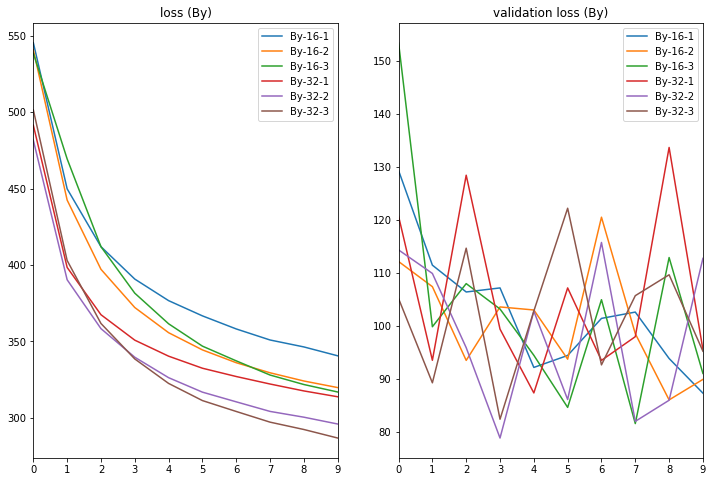

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
loss[names[::2]].plot(ax=ax[0], title='loss (By)')
val_loss[names[::2]].plot(ax=ax[1], title='validation loss (By)')

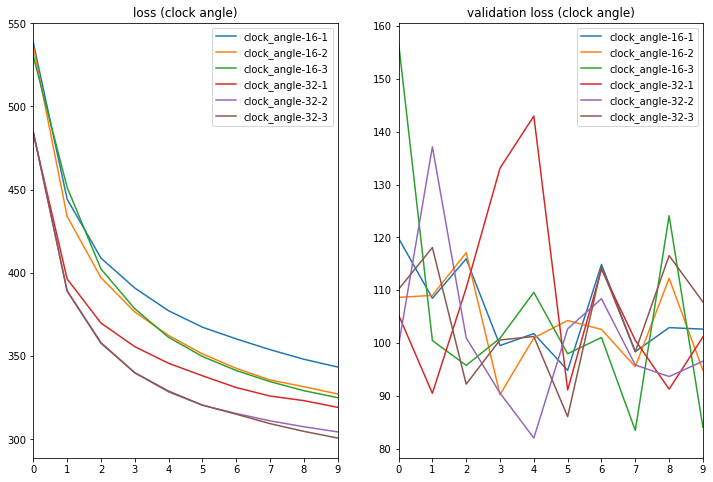

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
loss[names[1::2]].plot(ax=ax[0], title='loss (clock angle)')
val_loss[names[1::2]].plot(ax=ax[1], title='validation loss (clock angle)')

## How does the input choice effect the loss?

Let's plot the loss and validation loss for our different model trials.  Specifically, in each plot, we'll show the model that used `B`<sub>`y`</sub> and compare it with the analogous model that was trained on IMF clock-angle data.

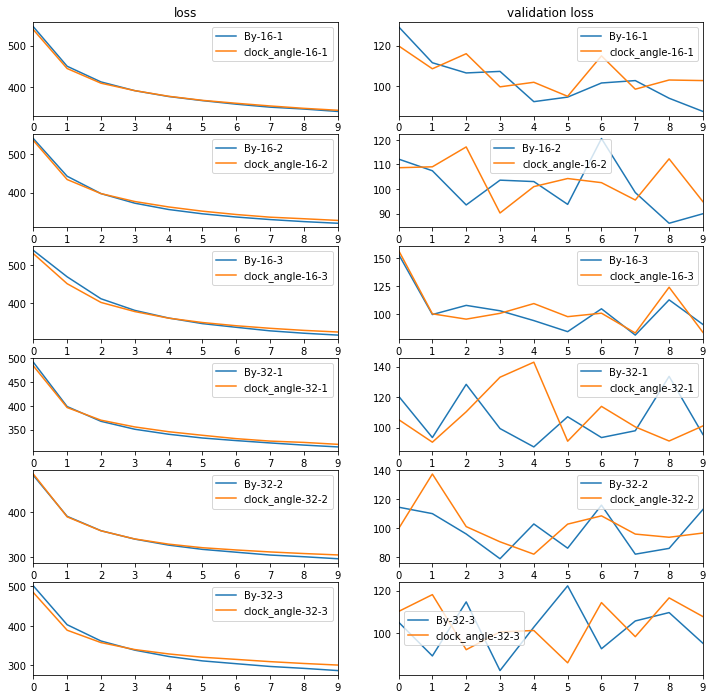

In [28]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 12))
for i in range(0, 12, 2):
    kwargs = dict(title='loss') if not i else dict()
    loss[names[i:i+2]].plot(ax=ax[i//2, 0], **kwargs)
    kwargs = dict(title='validation loss') if not i else dict()
    val_loss[names[i:i+2]].plot(ax=ax[i//2, 1], **kwargs)

Generally, the `B`<sub>`y`</sub> plots have slightly lower loss, but their validation loss charts are also (maybe) slightly more eratic.  It is unclear which is superior.

### Let's look at other ways to evaluate how well our models are performing...

How about checking the distribution of the individual errors?

In [29]:
_BIN_SIZE = 5  # 5 nT

def predict_accuracy_histogram(model, x_test, y_test, bin_size=_BIN_SIZE):
    """Make predictions with the model and bin the differences."""
    y_predict = model.predict(x_test)
    differences = (y_test - y_predict).ravel()
    diff_min = differences.min()
    diff_max = differences.max()
    half_bin = bin_size / 2.  # Shift the bins by half a binsize so that they are centered on 0.
    b_min = int(np.floor(diff_min / bin_size)) * bin_size - half_bin
    b_max = int(np.ceil(diff_max / bin_size)) * bin_size + half_bin + 1
    h_vals, bins = np.histogram(differences, np.arange(b_min, b_max, bin_size), density=False)

    plot_bins = (bins[:-1].astype(float) + bins[1:]) / 2
    h_vals = h_vals.astype(float)
    h_vals /= len(differences)  # Normalize to frequency-per-bin
    return plot_bins, h_vals

In [30]:
dsets = {}
dsets_validate = {}
input_shapes = {}
for xxx in 'By', 'clock_angle':
    dsets[xxx] = preprocessing.train_test_split(
        omni_lo_res,
        ['Bz', xxx, 'DynamicPressure'],
        FIELDS_PREDICT,
        n_points_behind=LOOK_BEHIND_SPAN,
        n_points_ahead=LOOK_AHEAD_SPAN)

    x_train, y_train, x_test, y_test = dsets[xxx]
    dsets_validate[xxx] = x_train[-n_validate:], y_train[-n_validate:]
    input_shapes[xxx] = (LOOK_BEHIND_SPAN, x_train.shape[2])

In [31]:
error_histogram = []
for m in recent_models:
    dset = dsets_validate['By'] if 'By' in name else dsets_validate['clock_angle']
    x_validate, y_validate = dset
    plot_bins, error_counts = predict_accuracy_histogram(m, x_validate, y_validate)
    sys.stdout.write('Predictions measured for %s\n' % m.name)
    sys.stdout.flush()
    error_histogram.append((plot_bins, error_counts, m))

Predictions measured for fld-By-stacks-1-hidden-16
Predictions measured for fld-clock_angle-stacks-1-hidden-16
Predictions measured for fld-By-stacks-2-hidden-16
Predictions measured for fld-clock_angle-stacks-2-hidden-16
Predictions measured for fld-By-stacks-3-hidden-16
Predictions measured for fld-clock_angle-stacks-3-hidden-16
Predictions measured for fld-By-stacks-1-hidden-32
Predictions measured for fld-clock_angle-stacks-1-hidden-32
Predictions measured for fld-By-stacks-2-hidden-32
Predictions measured for fld-clock_angle-stacks-2-hidden-32
Predictions measured for fld-By-stacks-3-hidden-32
Predictions measured for fld-clock_angle-stacks-3-hidden-32


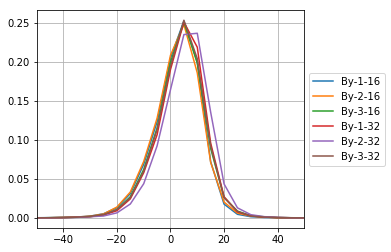

In [32]:
for bins, error_counts, m in error_histogram[::2]:
    legend_name = m.name.replace('fld-', '').replace('stacks-', '').replace('hidden-', '')
    plt.plot(bins, error_counts, label=legend_name)

ax = plt.gca()
ax.set_xlim(-50, 50)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.grid()
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

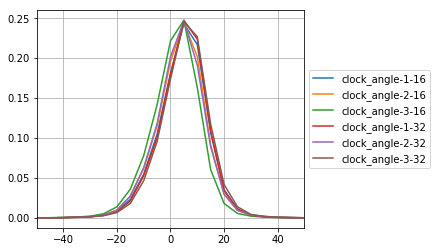

In [33]:
for bins, error_counts, m in error_histogram[1::2]:
    legend_name = m.name.replace('fld-', '').replace('stacks-', '').replace('hidden-', '')
    plt.plot(bins, error_counts, label=legend_name)

ax = plt.gca()
ax.set_xlim(-50, 50)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.grid()
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Interestingly enough, we seem to be systematically under-predicting the SymH by about 5nT.  It seems like the algorithm would get a better MSE if it figured out that it could just add the offset to whatever it was predicting before ...

### How do these compare to the testing dataset?

In [34]:
error_histogram = []
for m in recent_models:
    dset = dsets['By'] if 'By' in name else dsets['clock_angle']
    _, _, x_test, y_test = dset
    plot_bins, error_counts = predict_accuracy_histogram(m, x_test, y_test)
    sys.stdout.write('Predictions measured for %s\n' % m.name)
    sys.stdout.flush()
    error_histogram.append((plot_bins, error_counts, m))

Predictions measured for fld-By-stacks-1-hidden-16
Predictions measured for fld-clock_angle-stacks-1-hidden-16
Predictions measured for fld-By-stacks-2-hidden-16
Predictions measured for fld-clock_angle-stacks-2-hidden-16
Predictions measured for fld-By-stacks-3-hidden-16
Predictions measured for fld-clock_angle-stacks-3-hidden-16
Predictions measured for fld-By-stacks-1-hidden-32
Predictions measured for fld-clock_angle-stacks-1-hidden-32
Predictions measured for fld-By-stacks-2-hidden-32
Predictions measured for fld-clock_angle-stacks-2-hidden-32
Predictions measured for fld-By-stacks-3-hidden-32
Predictions measured for fld-clock_angle-stacks-3-hidden-32


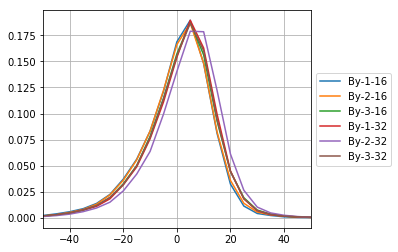

In [35]:
for bins, error_counts, m in error_histogram[::2]:
    legend_name = m.name.replace('fld-', '').replace('stacks-', '').replace('hidden-', '')
    plt.plot(bins, error_counts, label=legend_name)

ax = plt.gca()
ax.set_xlim(-50, 50)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.grid()
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

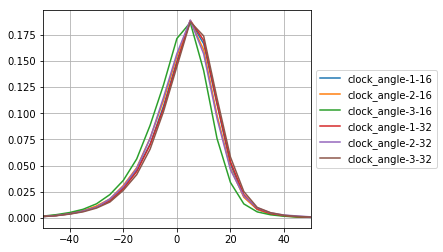

In [36]:
for bins, error_counts, m in error_histogram[1::2]:
    legend_name = m.name.replace('fld-', '').replace('stacks-', '').replace('hidden-', '')
    plt.plot(bins, error_counts, label=legend_name)

ax = plt.gca()
ax.set_xlim(-50, 50)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.grid()
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Let's look at some events with our better trained models . . .

### fld-clock_angle-stacks-2-hidden-16

In [37]:
plot_model = recent_models[3]

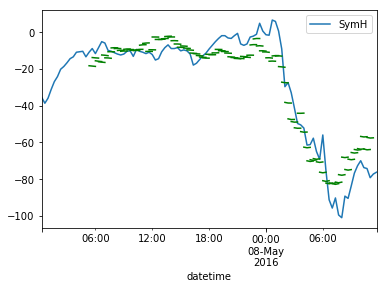

In [38]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2016-05-07'),
        pd.Timestamp('2016-05-08T12:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

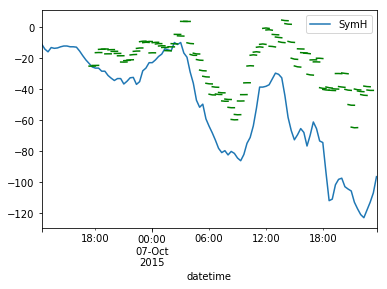

In [39]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2015-10-06T12:00:00'),
        pd.Timestamp('2015-10-08T00:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

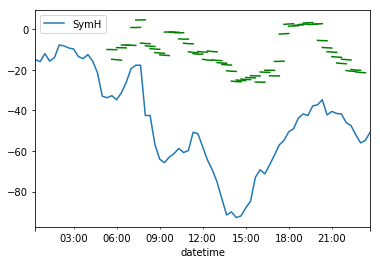

In [40]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2015-09-11T00:00:00'),
        pd.Timestamp('2015-09-12T00:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

### fld-clock_angle-stacks-1-hidden-16

In [41]:
plot_model = recent_models[1]

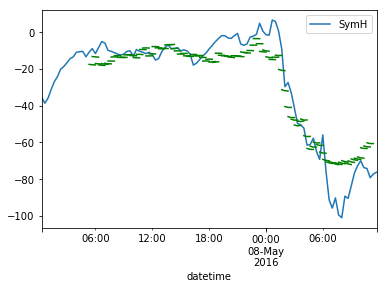

In [42]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2016-05-07'),
        pd.Timestamp('2016-05-08T12:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

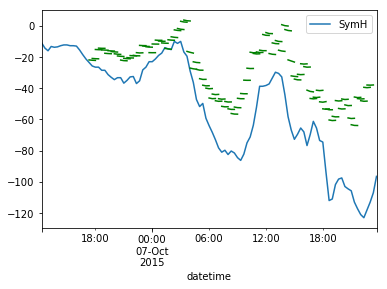

In [43]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2015-10-06T12:00:00'),
        pd.Timestamp('2015-10-08T00:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

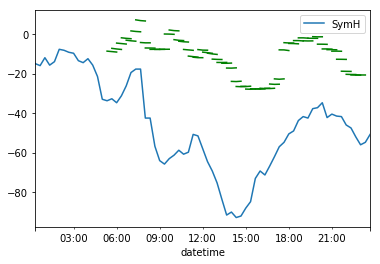

In [44]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2015-09-11T00:00:00'),
        pd.Timestamp('2015-09-12T00:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

### fld-By-stacks-2-hidden-16

In [45]:
plot_model = recent_models[2]

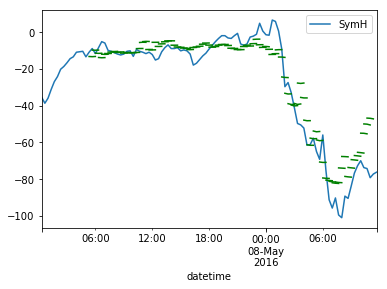

In [46]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2016-05-07'),
        pd.Timestamp('2016-05-08T12:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

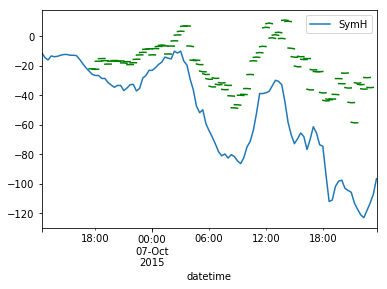

In [47]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2015-10-06T12:00:00'),
        pd.Timestamp('2015-10-08T00:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

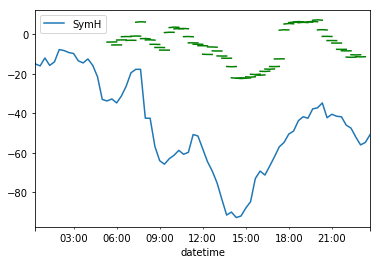

In [48]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2015-09-11T00:00:00'),
        pd.Timestamp('2015-09-12T00:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

### fld-By-stacks-1-hidden-16

In [49]:
plot_model = recent_models[0]

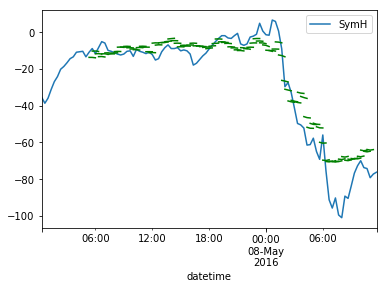

In [50]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2016-05-07'),
        pd.Timestamp('2016-05-08T12:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

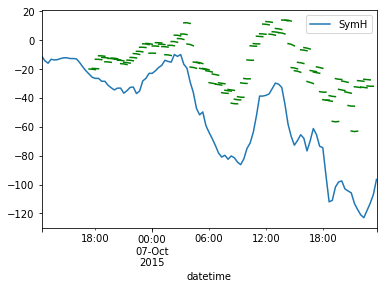

In [51]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2015-10-06T12:00:00'),
        pd.Timestamp('2015-10-08T00:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

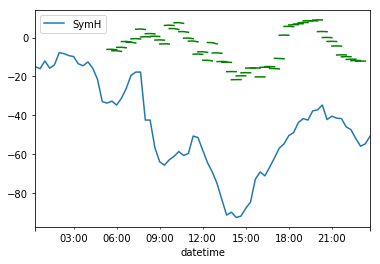

In [52]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2015-09-11T00:00:00'),
        pd.Timestamp('2015-09-12T00:00:00'),
        FIELDS,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

### What if we can use SymH as a predictor?

In [53]:
stacks = 1
hidden = 16

x_train, y_train, x_test, y_test = preprocessing.train_test_split(
    omni_lo_res,
    fields + FIELDS_PREDICT,
    FIELDS_PREDICT,
    n_points_behind=LOOK_BEHIND_SPAN,
    n_points_ahead=LOOK_AHEAD_SPAN)

input_shape = (LOOK_BEHIND_SPAN, x_train.shape[2])

m = model.ModelWrapper(
    model.build_model(input_shape, LOOK_AHEAD_SPAN, hidden=hidden, rnn_type=GRU, stacks=stacks, dropout=.3),
    name='SymH-fld-%s-stacks-%s-hidden-%s' % (fields[1], stacks, hidden))
m.save_path = './model-checkpoints/'  # save in the model-checkpoints directory.
m.save_freq = 5  # When training, save every 5 epochs.    
model.compile_model(m)
model.compile_model(m)

if READ_PRE_TRAINED_MODELS:
    m = m.restore(os.path.join(m.save_path, m.name + '.%s.json' % PRE_TRAINED_EPOCH))
else:
    n_validate = int(len(x_train) * .2)
    X = x_train[:-n_validate]
    Y = y_train[:-n_validate]
    x_validate = x_train[-n_validate:]
    y_validate = y_train[-n_validate:]
    m.fit(
        X,
        Y,
        epochs=10,
        batch_size=400,
        validation_data=(x_validate, y_validate))

models.append(m)

Train on 315449 samples, validate on 78862 samples
Epoch 1/10
315449/315449 [==============================] - 27s - loss: 494.0932 - val_loss: 31.3628
Epoch 2/10
315449/315449 [==============================] - 25s - loss: 299.4315 - val_loss: 12.9051
Epoch 3/10
315449/315449 [==============================] - 25s - loss: 209.4252 - val_loss: 8.5022
Epoch 4/10
315449/315449 [==============================] - 25s - loss: 160.6107 - val_loss: 6.8976
Epoch 5/10
315449/315449 [==============================] - 26s - loss: 129.6054 - val_loss: 6.4513
Epoch 6/10
315449/315449 [==============================] - 25s - loss: 109.1440 - val_loss: 6.3685
Epoch 7/10
315449/315449 [==============================] - 25s - loss: 95.0801 - val_loss: 6.4230
Epoch 8/10
315449/315449 [==============================] - 25s - loss: 83.7406 - val_loss: 6.4134
Epoch 9/10
315449/315449 [==============================] - 26s - loss: 75.1460 - val_loss: 6.4542
Epoch 10/10
315449/315449 [=======================

In [54]:
symH_model = m

In [55]:
bins, error_counts = predict_accuracy_histogram(symH_model, x_test, y_test)

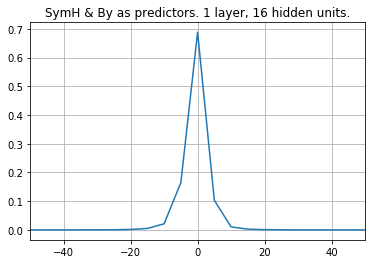

In [56]:
plt.plot(bins, error_counts)

ax = plt.gca()
ax.set_xlim(-50, 50)
ax.set_title('SymH & By as predictors. 1 layer, 16 hidden units.')
ax.grid()

In [57]:
plot_model = symH_model

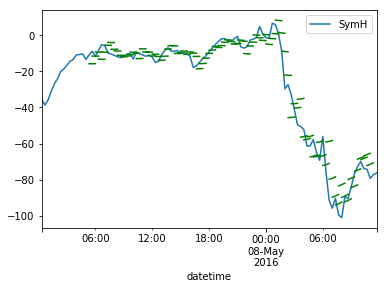

In [58]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2016-05-07'),
        pd.Timestamp('2016-05-08T12:00:00'),
        FIELDS + FIELDS_PREDICT,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

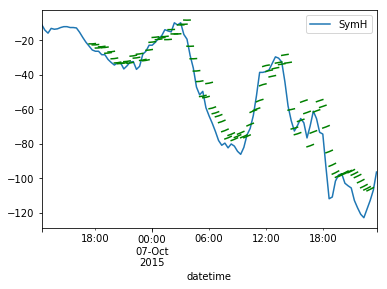

In [59]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2015-10-06T12:00:00'),
        pd.Timestamp('2015-10-08T00:00:00'),
        FIELDS + FIELDS_PREDICT,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)

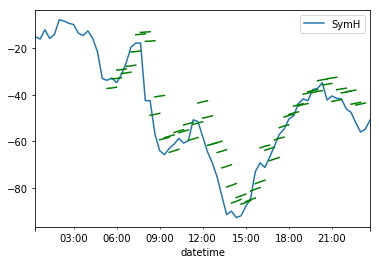

In [60]:
viz.plot_event_predictions(
        plot_model,
        omni_lo_res,
        pd.Timestamp('2015-09-11T00:00:00'),
        pd.Timestamp('2015-09-12T00:00:00'),
        FIELDS + FIELDS_PREDICT,
        FIELDS_PREDICT,
        n_points_behind=15,
        n_points_ahead=3)